Mounted at /content/gdrive
 Google Drive mounted & paths ready.
 Loaded datasets
timeframes: (1859, 9) game: (2814, 6) phone: (3255, 6)
Total Sleep Time calculated successfully.
   user_id                    bt_yes                  wt_today  \
0        1 2020-06-01 23:30:00+00:00 2020-06-02 07:20:00+00:00   
1        1 2020-06-04 01:15:00+00:00 2020-06-04 06:45:00+00:00   
2        1 2020-06-05 00:00:00+00:00 2020-06-05 06:45:00+00:00   
3        1 2020-06-06 02:44:00+00:00 2020-06-06 09:50:00+00:00   
4        1 2020-06-07 02:30:00+00:00 2020-06-07 09:43:00+00:00   

   total_sleep_minutes  
0                470.0  
1                330.0  
2                405.0  
3                426.0  
4                433.0  
prebed_use converted successfully (max=1.000)
   user_id  prebed_use  prebed_use_minutes
2        2    0.000833            0.050000
3        2    0.000278            0.016667
4        2    0.000000            0.000000
5        2    0.000000            0.000000
7        2    

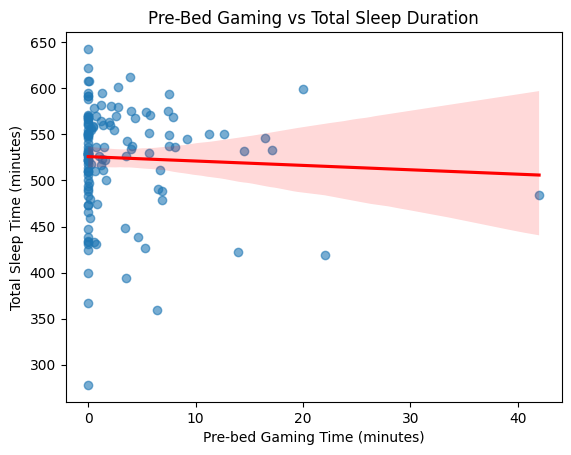

T-test Result → T=-0.810, p=0.419
Mean (Low): 520.57 min | Mean (High): 528.63 min | Δ=8.06 min
                             OLS Regression Results                            
Dep. Variable:     total_sleep_minutes   R-squared:                       0.053
Model:                             OLS   Adj. R-squared:                  0.031
Method:                  Least Squares   F-statistic:                     2.440
Date:                 Thu, 16 Oct 2025   Prob (F-statistic):             0.0673
Time:                         08:56:55   Log-Likelihood:                -728.94
No. Observations:                  134   AIC:                             1466.
Df Residuals:                      130   BIC:                             1477.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

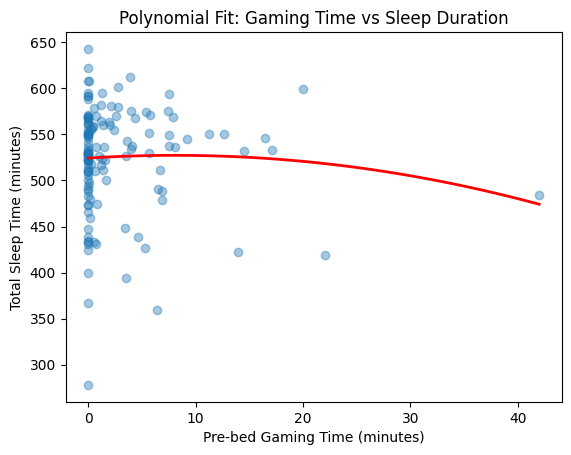

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Paths
BASE = "/content/gdrive/MyDrive/acdt/"
paths = {
    "timeframes": BASE + "timeframes.csv",
    "game": BASE + "game.csv",
    "phone": BASE + "phone.csv"
}
print(" Google Drive mounted & paths ready.")


# 1. Load Data

time_df = pd.read_csv(paths["timeframes"])
game_df = pd.read_csv(paths["game"])
phone_df = pd.read_csv(paths["phone"])

print(" Loaded datasets")
print("timeframes:", time_df.shape, "game:", game_df.shape, "phone:", phone_df.shape)


#  2. Generate total_sleep_minutes (Dependent Variable)

time_df["bt_yes"] = pd.to_datetime(time_df["bt_yes"], errors="coerce", utc=True)
time_df["wt_today"] = pd.to_datetime(time_df["wt_today"], errors="coerce", utc=True)

# Compute total sleep minutes
time_df["total_sleep_minutes"] = (time_df["wt_today"] - time_df["bt_yes"]).dt.total_seconds() / 60
time_df.loc[time_df["total_sleep_minutes"] < 0, "total_sleep_minutes"] += 24 * 60

print("Total Sleep Time calculated successfully.")
print(time_df[["user_id", "bt_yes", "wt_today", "total_sleep_minutes"]].head())


# 3. Create Independent Variable (Pre-bed Gaming Time)

if "prebed_use" in game_df.columns:
    mx = game_df["prebed_use"].dropna().max()
    if mx <= 2:
        game_df["prebed_use_minutes"] = game_df["prebed_use"] * 60
    else:
        game_df["prebed_use_minutes"] = game_df["prebed_use"]
else:
    raise ValueError(" Missing column: 'prebed_use' in game.csv")

# remove invalid or negative values
game_df = game_df[(game_df["prebed_use_minutes"] >= 0) & (game_df["prebed_use_minutes"] <= 480)]

print(f"prebed_use converted successfully (max={mx:.3f})")
print(game_df[["user_id", "prebed_use", "prebed_use_minutes"]].head())


# 4. Merge Data by user_id

df = pd.merge(
    time_df[["user_id", "bt_yes", "total_sleep_minutes"]],
    game_df[["user_id", "prebed_use_minutes"]],
    on="user_id", how="inner"
)
df = pd.merge(df, phone_df[["user_id", "daytime_use", "postbed_use"]], on="user_id", how="left")

# Filter and clean
df = df[(df["total_sleep_minutes"] >= 180) & (df["total_sleep_minutes"] <= 960)]
df.dropna(inplace=True)

# Average per user (avoid multiple log rows)
df = df.groupby("user_id", as_index=False).mean()

print(f" Cleaned data: {df.shape[0]} users")
print(df.head())


#  5. Simple Linear Regression

X = sm.add_constant(df["prebed_use_minutes"])
model = sm.OLS(df["total_sleep_minutes"], X).fit()
print(model.summary())

# Visualization
sns.regplot(x="prebed_use_minutes", y="total_sleep_minutes", data=df,
            scatter_kws={"alpha":0.6}, line_kws={"color":"red"})
plt.xlabel("Pre-bed Gaming Time (minutes)")
plt.ylabel("Total Sleep Time (minutes)")
plt.title("Pre-Bed Gaming vs Total Sleep Duration")
plt.show()


# 6. T-test (High vs Low gamers)

median_gaming = df["prebed_use_minutes"].median()
low = df[df["prebed_use_minutes"] <= median_gaming]["total_sleep_minutes"]
high = df[df["prebed_use_minutes"] > median_gaming]["total_sleep_minutes"]

t, p = stats.ttest_ind(low, high, equal_var=False)
print(f"T-test Result → T={t:.3f}, p={p:.3f}")
print(f"Mean (Low): {low.mean():.2f} min | Mean (High): {high.mean():.2f} min | Δ={high.mean()-low.mean():.2f} min")


# 7. Multiple Regression (Control daytime_use, postbed_use)

X2 = sm.add_constant(df[["prebed_use_minutes", "daytime_use", "postbed_use"]])
model2 = sm.OLS(df["total_sleep_minutes"], X2).fit()
print(model2.summary())


# 8. Mediation Analysis (Gaming → Bedtime Hour → Sleep)

df["bt_yes_hour"] = pd.to_datetime(df["bt_yes"]).dt.hour + pd.to_datetime(df["bt_yes"]).dt.minute/60

# Step a: prebed_use → bedtime
Xa = sm.add_constant(df["prebed_use_minutes"])
model_a = sm.OLS(df["bt_yes_hour"], Xa).fit()

# Step b: bedtime & prebed_use → sleep
Xb = sm.add_constant(df[["bt_yes_hour", "prebed_use_minutes"]])
model_b = sm.OLS(df["total_sleep_minutes"], Xb).fit()

a, b = model_a.params["prebed_use_minutes"], model_b.params["bt_yes_hour"]
sa, sb = model_a.bse["prebed_use_minutes"], model_b.bse["bt_yes_hour"]
z = a * b / np.sqrt(b**2 * sa**2 + a**2 * sb**2)

print("----- Mediation Results -----")
print(model_b.summary())
print(f" Sobel z = {z:.3f} (|z|>1.96 ⇒ significant mediation at 5%)")


#  9. Polynomial Regression (Nonlinear check)

df["prebed_sq"] = df["prebed_use_minutes"] ** 2
X3 = sm.add_constant(df[["prebed_use_minutes", "prebed_sq"]])
model3 = sm.OLS(df["total_sleep_minutes"], X3).fit()
print(model3.summary())

plt.scatter(df["prebed_use_minutes"], df["total_sleep_minutes"], alpha=0.4)
x_seq = np.linspace(0, df["prebed_use_minutes"].max(), 100)
y_pred = model3.params["const"] + model3.params["prebed_use_minutes"]*x_seq + model3.params["prebed_sq"]*(x_seq**2)
plt.plot(x_seq, y_pred, color="red", linewidth=2)
plt.xlabel("Pre-bed Gaming Time (minutes)")
plt.ylabel("Total Sleep Time (minutes)")
plt.title("Polynomial Fit: Gaming Time vs Sleep Duration")
plt.show()


/tmp/ipython-input-85039144.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


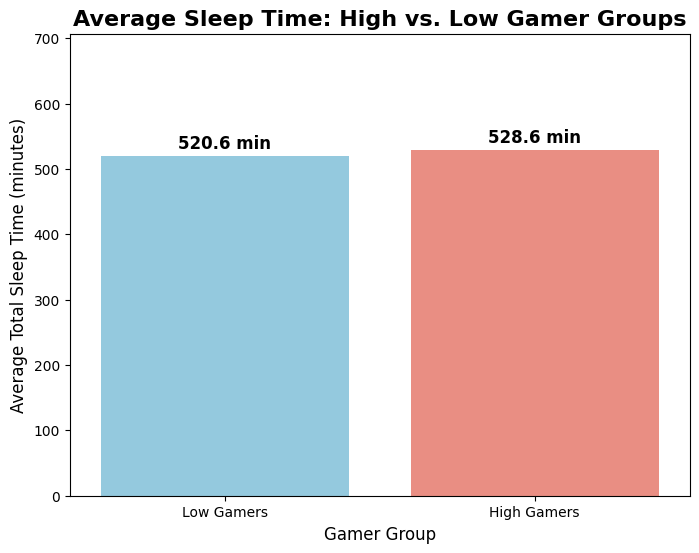

In [ ]:

# VISUALIZATION 1: Group Comparison (T-test)

import seaborn as sns
import matplotlib.pyplot as plt

# Divide into groups based on the median
median_gaming = df["prebed_use_minutes"].median()
df['gamer_group'] = 'High Gamers'
df.loc[df['prebed_use_minutes'] <= median_gaming, 'gamer_group'] = 'Low Gamers'

# Calculate the average sleep duration
mean_values = df.groupby('gamer_group')['total_sleep_minutes'].mean().reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x='gamer_group', y='total_sleep_minutes', data=df,
    palette={'Low Gamers': 'skyblue', 'High Gamers': 'salmon'},
    estimator='mean', errorbar=None
)

# Show average values above the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f} min",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points',
                fontsize=12, weight='bold')

plt.title("Average Sleep Time: High vs. Low Gamer Groups", fontsize=16, weight='bold')
plt.xlabel("Gamer Group", fontsize=12)
plt.ylabel("Average Total Sleep Time (minutes)", fontsize=12)
plt.ylim(0, df['total_sleep_minutes'].max()*1.1)
plt.show()


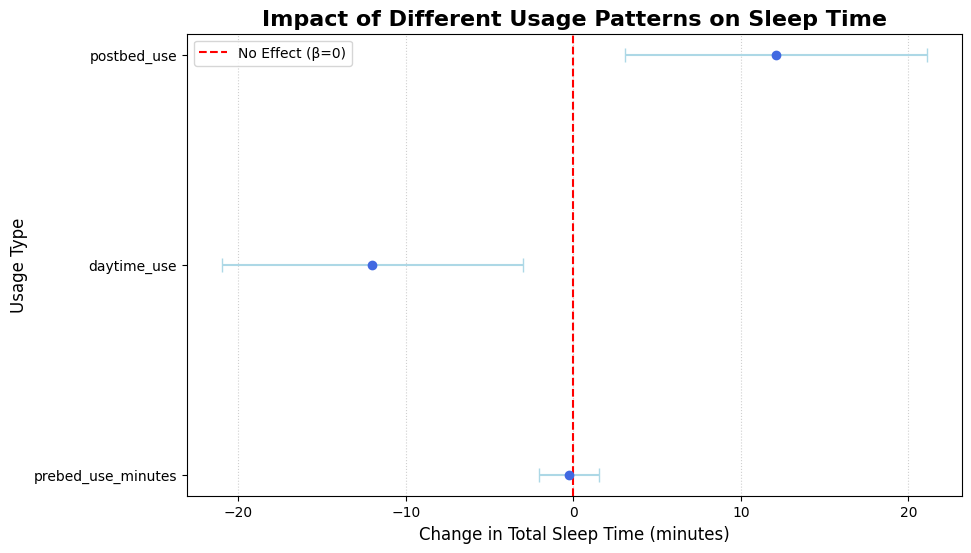

In [ ]:

# VISUALIZATION 2: Coefficient Plot (Multiple Regression)

import matplotlib.pyplot as plt

# Extract regression coefficients and confidence intervals from model2
conf = model2.conf_int()
conf['coef'] = model2.params
conf.columns = ['2.5%', '97.5%', 'coef']
conf = conf.iloc[1:]  # remove const

plt.figure(figsize=(10, 6))
plt.errorbar(
    x=conf['coef'], y=conf.index,
    xerr=[conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']],
    fmt='o', color='royalblue', ecolor='lightblue', capsize=5
)
plt.axvline(x=0, color='red', linestyle='--', label='No Effect (β=0)')
plt.title("Impact of Different Usage Patterns on Sleep Time", fontsize=16, weight='bold')
plt.xlabel("Change in Total Sleep Time (minutes)", fontsize=12)
plt.ylabel("Usage Type", fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.show()


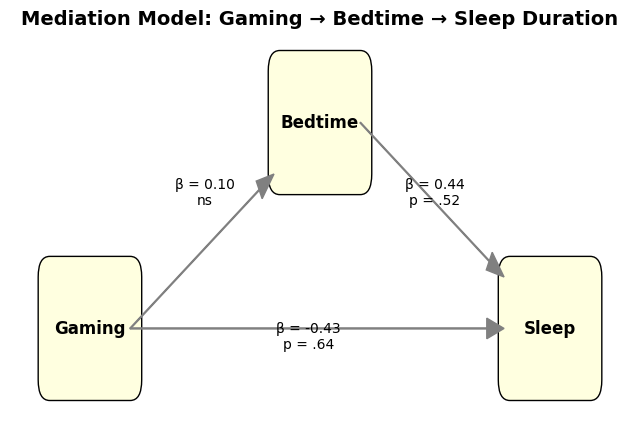

In [ ]:

# VISUALIZATION 3: Mediation Diagram

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(8,5))
ax = plt.gca()

# node coordinates
nodes = {
    "Gaming": (0.1, 0.5),
    "Bedtime": (0.5, 0.7),
    "Sleep": (0.9, 0.5)
}

# Plot a box
for name, (x, y) in nodes.items():
    ax.add_patch(mpatches.FancyBboxPatch((x-0.07, y-0.05), 0.14, 0.1,
                                         boxstyle="round,pad=0.02", fc="lightyellow", ec="black"))
    plt.text(x, y, name, ha="center", va="center", fontsize=12, weight='bold')

# Arrow (Path A: Gaming→Bedtime)
plt.arrow(0.17, 0.5, 0.25, 0.15, head_width=0.02, length_includes_head=True, color='gray')
plt.text(0.3, 0.62, "β = 0.10\nns", fontsize=10, ha='center')

# Arrow (Path B: Bedtime → Sleep Duration)
plt.arrow(0.57, 0.7, 0.25, -0.15, head_width=0.02, length_includes_head=True, color='gray')
plt.text(0.7, 0.62, "β = 0.44\np = .52", fontsize=10, ha='center')

# Arrow (Path C': Gaming→ Sleep Duration)
plt.arrow(0.17, 0.5, 0.65, 0.0, head_width=0.02, length_includes_head=True, color='gray')
plt.text(0.48, 0.48, "β = -0.43\np = .64", fontsize=10, ha='center')

plt.axis('off')
plt.title("Mediation Model: Gaming → Bedtime → Sleep Duration", fontsize=14, weight='bold')
plt.show()


Mounted at /content/gdrive
[Diagnostics]
- Negative gaming minutes fixed to 0: 0
- Clipped very high gaming minutes (> 22.1): 49
- Negative sleep durations corrected (+24h): 0
- Sleep durations clipped below 365 or above 640: 184
- Users in final dataset: 134


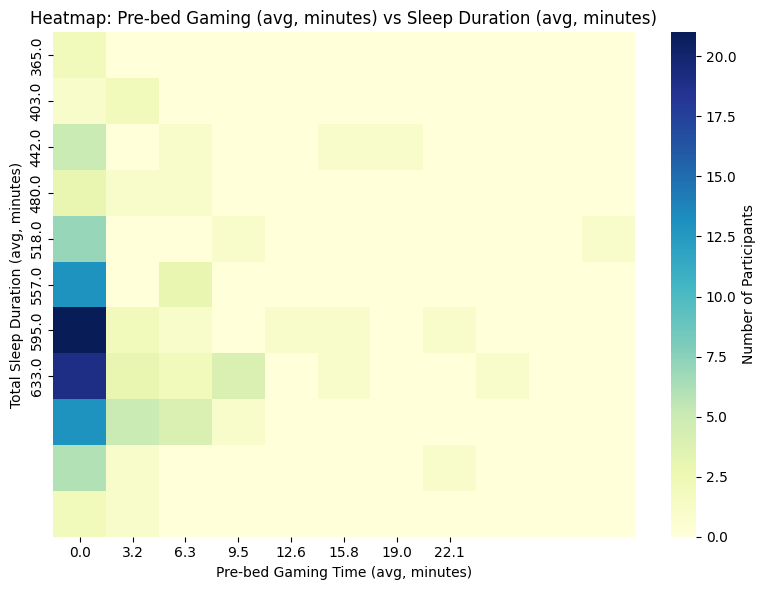

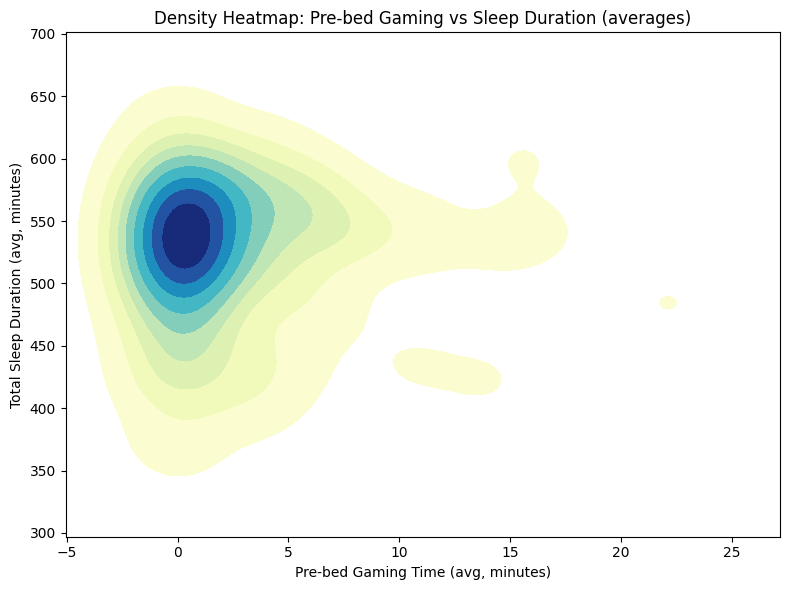

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", 50)


# 1. Define Paths

BASE = "/content/gdrive/MyDrive/acdt/"
paths = {
    "game": BASE + "game.csv",
    "timeframes": BASE + "timeframes.csv"
}


# 2. Load Data

game = pd.read_csv(paths["game"])
time = pd.read_csv(paths["timeframes"])


# 3. Clean & Correct — Gaming Time (pre-bed)

# - Replace -999 with NaN
# - Ensure consistent time unit (minutes)
# - Negative values set to 0 (not dropped)
# - Clip extreme values (above 95th percentile or 180 min)

game = game.replace(-999, np.nan)
game["prebed_use"] = pd.to_numeric(game["prebed_use"], errors="coerce")

# Detect whether the column is in hours
mx = game["prebed_use"].dropna().max()
if pd.notna(mx) and mx <= 2:
    game["prebed_min"] = game["prebed_use"] * 60.0
else:
    game["prebed_min"] = game["prebed_use"].copy()

# Replace negative values with 0 (to avoid dropping users)
neg_cnt = int((game["prebed_min"] < 0).sum())
game.loc[game["prebed_min"] < 0, "prebed_min"] = 0.0

# Clip extreme outliers
p95 = game["prebed_min"].quantile(0.95)
cap = float(min(180.0, p95 if pd.notna(p95) else 180.0))
clip_hi_cnt = int((game["prebed_min"] > cap).sum())
game["prebed_min"] = game["prebed_min"].clip(lower=0.0, upper=cap)

# Compute user-level mean values
g_summary = (
    game.groupby("user_id", as_index=False)["prebed_min"]
        .mean()
        .rename(columns={"prebed_min": "prebed_min_avg"})
)


# 4. Clean & Correct — Sleep Time

# - Parse times (bt_yes = bedtime, wt_today = wake time)
# - Handle negative differences (add +24h)
# - Clip unrealistic durations (3–12 hours)

for c in ["bt_yes", "wt_today"]:
    time[c] = pd.to_datetime(time[c], errors="coerce", utc=True)

# Compute sleep duration in minutes
time["sleep_min"] = (time["wt_today"] - time["bt_yes"]).dt.total_seconds() / 60.0

# Correct negative values (crossing midnight)
neg_sleep_cnt = int((time["sleep_min"] < 0).sum())
time.loc[time["sleep_min"] < 0, "sleep_min"] += 24.0 * 60.0

# Remove extreme outliers using quantiles
low_q = time["sleep_min"].quantile(0.05)
hi_q = time["sleep_min"].quantile(0.95)

# Enforce logical bounds (3h–12h)
low_bound = max(180.0, float(low_q) if pd.notna(low_q) else 180.0)
hi_bound  = min(720.0, float(hi_q)  if pd.notna(hi_q)  else 720.0)

clip_lo_cnt = int((time["sleep_min"] < low_bound).sum())
clip_hi2_cnt = int((time["sleep_min"] > hi_bound).sum())
time["sleep_min"] = time["sleep_min"].clip(lower=low_bound, upper=hi_bound)

# Compute user-level mean values
t_summary = (
    time.groupby("user_id", as_index=False)["sleep_min"]
        .mean()
        .rename(columns={"sleep_min": "sleep_min_avg"})
)


# 5. Merge Final Dataset

df = pd.merge(t_summary, g_summary, on="user_id", how="inner")
n_users = len(df)

print(f"[Diagnostics]")
print(f"- Negative gaming minutes fixed to 0: {neg_cnt}")
print(f"- Clipped very high gaming minutes (> {cap:.1f}): {clip_hi_cnt}")
print(f"- Negative sleep durations corrected (+24h): {neg_sleep_cnt}")
print(f"- Sleep durations clipped below {low_bound:.0f} or above {hi_bound:.0f}: "
      f"{clip_lo_cnt + clip_hi2_cnt}")
print(f"- Users in final dataset: {n_users}")


# 6. Visualization 1 — Heatmap (2D Histogram)

xbins = min(30, max(10, int(np.sqrt(n_users))))
ybins = xbins

H, xedges, yedges = np.histogram2d(
    df["prebed_min_avg"], df["sleep_min_avg"],
    bins=(xbins, ybins)
)

plt.figure(figsize=(8,6))
sns.heatmap(
    H.T,
    cmap="YlGnBu",
    cbar_kws={"label": "Number of Participants"},
    xticklabels=np.round(np.linspace(df["prebed_min_avg"].min(), df["prebed_min_avg"].max(), 8), 1),
    yticklabels=np.round(np.linspace(df["sleep_min_avg"].min(), df["sleep_min_avg"].max(), 8), 0)
)
plt.title("Heatmap: Pre-bed Gaming (avg, minutes) vs Sleep Duration (avg, minutes)")
plt.xlabel("Pre-bed Gaming Time (avg, minutes)")
plt.ylabel("Total Sleep Duration (avg, minutes)")
plt.tight_layout()
plt.show()


# 7. Visualization 2 — KDE Density Heatmap

plt.figure(figsize=(8,6))
sns.kdeplot(
    data=df, x="prebed_min_avg", y="sleep_min_avg",
    fill=True, thresh=0.05, cmap="YlGnBu"
)
plt.title("Density Heatmap: Pre-bed Gaming vs Sleep Duration (averages)")
plt.xlabel("Pre-bed Gaming Time (avg, minutes)")
plt.ylabel("Total Sleep Duration (avg, minutes)")
plt.tight_layout()
plt.show()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


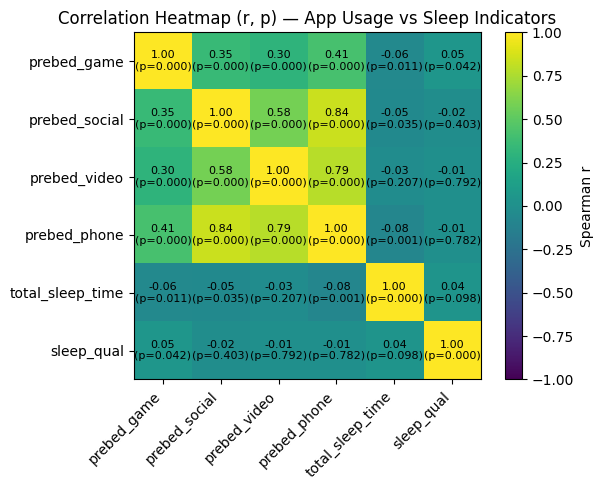

 Correlation heatmap with p-values saved to: /content/gdrive/MyDrive/acdt/heatmap_app_usage_vs_sleep_pval.png


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# 1. Define Paths (edit BASE if needed)

BASE = "/content/gdrive/MyDrive/acdt/"
OUT_PATH = os.path.join(BASE, "heatmap_app_usage_vs_sleep_pval.png")

paths = {
    "game": BASE + "game.csv",
    "social": BASE + "social.csv",
    "video": BASE + "video.csv",
    "phone": BASE + "phone.csv",
    "timeframes": BASE + "timeframes.csv"
}


# 2. Load Data

game   = pd.read_csv(paths["game"])
social = pd.read_csv(paths["social"])
video  = pd.read_csv(paths["video"])
phone  = pd.read_csv(paths["phone"])
time   = pd.read_csv(paths["timeframes"])


# 3. Compute Sleep Duration (in minutes)

# - Parse timestamps
# - Add +1 day if wake time < bedtime (crosses midnight)
# - Remove unrealistic sleep durations (<2h or >14h)

time["bt_yes"] = pd.to_datetime(time["bt_yes"], errors="coerce")
time["wt_today"] = pd.to_datetime(time["wt_today"], errors="coerce")

wt_adj = time["wt_today"]
bt = time["bt_yes"]
cross_mid = wt_adj < bt
wt_adj = wt_adj.where(~cross_mid, wt_adj + pd.Timedelta(days=1))
time["total_sleep_time"] = (wt_adj - bt).dt.total_seconds() / 60

time = time[(time["total_sleep_time"] >= 120) & (time["total_sleep_time"] <= 14*60)]

# If study_day is missing, reconstruct it by order per user
if "study_day" not in time.columns:
    time = time.sort_values(["user_id", "wt_today"])
    time["study_day"] = time.groupby("user_id").cumcount() + 1


# 4. Prepare App Data (Game, Social, Video, Phone)

# Extract only relevant columns (user_id, study_day, prebed_use)
# Rename each to unified form (prebed_game, prebed_social, etc.)

def prep_app(df, name):
    cols = [c for c in ["user_id", "study_day", "prebed_use"] if c in df.columns]
    df = df[cols].copy()
    if "study_day" not in df.columns:
        df = df.sort_values(["user_id"])
        df["study_day"] = df.groupby("user_id").cumcount() + 1
    df = df.rename(columns={"prebed_use": f"prebed_{name}"})
    return df

game_p   = prep_app(game, "game")
social_p = prep_app(social, "social")
video_p  = prep_app(video, "video")
phone_p  = prep_app(phone, "phone")


# 5. Merge Datasets

# Merge app data with sleep information (per user & study_day)
# Fill missing app-use values with 0 (non-use days)

base = time[["user_id", "study_day", "total_sleep_time", "sleep_qual"]].copy()
merged = (
    base.merge(game_p, on=["user_id", "study_day"], how="left")
        .merge(social_p, on=["user_id", "study_day"], how="left")
        .merge(video_p, on=["user_id", "study_day"], how="left")
        .merge(phone_p, on=["user_id", "study_day"], how="left")
)

for c in ["prebed_game", "prebed_social", "prebed_video", "prebed_phone"]:
    if c in merged.columns:
        merged[c] = merged[c].fillna(0)


# 6. Compute Correlations and p-values

# Use Spearman rank correlation to account for non-normal data

cols = ["prebed_game", "prebed_social", "prebed_video", "prebed_phone", "total_sleep_time", "sleep_qual"]
df = merged[cols].dropna()

corr = pd.DataFrame(index=cols, columns=cols, dtype=float)
pval = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in cols:
    for j in cols:
        r, p = stats.spearmanr(df[i], df[j], nan_policy="omit")
        corr.loc[i, j] = r
        pval.loc[i, j] = p


# 7. Visualization — Correlation Heatmap with p-values

plt.figure(figsize=(7,5))
im = plt.imshow(corr, interpolation="nearest", vmin=-1, vmax=1)
plt.title("Correlation Heatmap (r, p) — App Usage vs Sleep Indicators")
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)

# Annotate both r and p values inside each cell
for i in range(len(cols)):
    for j in range(len(cols)):
        r = corr.iloc[i, j]
        p = pval.iloc[i, j]
        if pd.notnull(r):
            plt.text(j, i, f"{r:.2f}\n(p={p:.3f})", ha="center", va="center", fontsize=8)

plt.colorbar(im, fraction=0.046, pad=0.04, label="Spearman r")
plt.tight_layout()
plt.savefig(OUT_PATH, dpi=150)
plt.show()

print(f" Correlation heatmap with p-values saved to: {OUT_PATH}")


Mounted at /content/gdrive
 Final merged data: (2814, 7)


,user_id,total_sleep_minutes,game,social,video,daytime,postbed
0,2,424.947368,0.007407,0.274561,8.966667,6.819444,0.127500
1,2,424.947368,0.007407,0.274561,8.966667,3.770278,0.007778
2,2,424.947368,0.007407,0.274561,8.966667,1.495833,0.298889
3,2,424.947368,0.007407,0.274561,8.966667,1.580000,0.557500
4,2,424.947368,0.007407,0.274561,8.966667,4.003889,0.000000


                             OLS Regression Results                            
Dep. Variable:     total_sleep_minutes   R-squared:                       0.030
Model:                             OLS   Adj. R-squared:                  0.028
Method:                  Least Squares   F-statistic:                     17.22
Date:                 Fri, 17 Oct 2025   Prob (F-statistic):           8.18e-17
Time:                         09:33:19   Log-Likelihood:                -15342.
No. Observations:                 2814   AIC:                         3.070e+04
Df Residuals:                     2808   BIC:                         3.073e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        548.4348      3.239    169.30

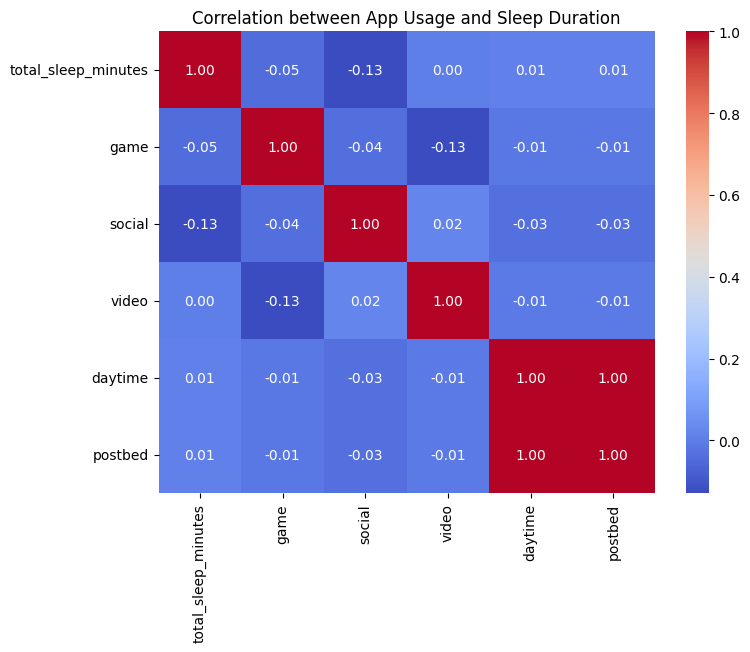


 Interpretation:
- Game shows a **negative** and statistically significant effect on sleep (β=-0.436, p=0.028).
- Social shows a **negative** and statistically significant effect on sleep (β=-0.773, p=0.000).
- Video shows a positive but **non-significant** effect (β=0.085, p=0.403).
- Daytime shows a **negative** and statistically significant effect on sleep (β=-3.104, p=0.000).
- Postbed shows a **positive** and statistically significant effect on sleep (β=3.120, p=0.000).


In [1]:

from google.colab import drive
drive.mount('/content/gdrive')


import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
BASE = "/content/gdrive/MyDrive/acdt/"
paths = {
    "timeframes": BASE + "timeframes.csv",
    "game": BASE + "game.csv",
    "social": BASE + "social.csv",
    "video": BASE + "video.csv",
    "phone": BASE + "phone.csv"
}

# Load Data
time_df = pd.read_csv(paths["timeframes"])
game_df = pd.read_csv(paths["game"])
social_df = pd.read_csv(paths["social"])
video_df = pd.read_csv(paths["video"])
phone_df = pd.read_csv(paths["phone"])

# 1 Create total_sleep_minutes
time_df["bt_yes"] = pd.to_datetime(time_df["bt_yes"], errors="coerce", utc=True)
time_df["wt_today"] = pd.to_datetime(time_df["wt_today"], errors="coerce", utc=True)
time_df["total_sleep_minutes"] = (time_df["wt_today"] - time_df["bt_yes"]).dt.total_seconds() / 60
time_df.loc[time_df["total_sleep_minutes"] < 0, "total_sleep_minutes"] += 24 * 60
time_df = time_df[(time_df["total_sleep_minutes"] >= 180) & (time_df["total_sleep_minutes"] <= 960)]
sleep_df = time_df.groupby("user_id", as_index=False)["total_sleep_minutes"].mean()

# 2️ Convert each app's prebed_use to minutes
def clean_prebed(df, colname="prebed_use"):
    if colname not in df.columns:
        raise ValueError(f"Missing column {colname}")
    mx = df[colname].dropna().max()
    if mx <= 2:
        df[f"{colname}_minutes"] = df[colname] * 60
    else:
        df[f"{colname}_minutes"] = df[colname]
    df = df[(df[f"{colname}_minutes"] >= 0) & (df[f"{colname}_minutes"] <= 480)]
    df = df.groupby("user_id", as_index=False)[f"{colname}_minutes"].mean()
    return df.rename(columns={f"{colname}_minutes": f"prebed_{colname}_minutes"})

game_clean = clean_prebed(game_df, "prebed_use")
social_clean = clean_prebed(social_df, "prebed_use")
video_clean = clean_prebed(video_df, "prebed_use")

# 3️ Merge all app + phone data
df = sleep_df.merge(game_clean, on="user_id", how="inner")
df = df.merge(social_clean, on="user_id", how="left", suffixes=("_game", "_social"))
df = df.merge(video_clean, on="user_id", how="left")
df = df.merge(phone_df[["user_id", "daytime_use", "postbed_use"]], on="user_id", how="left")
df.dropna(inplace=True)

# Rename columns to clean names
df.rename(columns={
    "prebed_prebed_use_minutes_game": "game",
    "prebed_prebed_use_minutes_social": "social",
    "prebed_prebed_use_minutes": "video",
    "daytime_use": "daytime",
    "postbed_use": "postbed"
}, inplace=True)

print(f" Final merged data: {df.shape}")
display(df.head())

# 4️ Multiple Regression (apps + phone)
X = df[["game", "social", "video", "daytime", "postbed"]]
X = sm.add_constant(X)
y = df["total_sleep_minutes"]

model_multi = sm.OLS(y, X).fit()
print(model_multi.summary())


print("\n Coefficient Summary:")
for var in X.columns[1:]:
    print(f"{var:<8} → β={model_multi.params[var]:.3f}, p={model_multi.pvalues[var]:.3f}")

r2 = model_multi.rsquared
sig_vars = [v for v in X.columns[1:] if model_multi.pvalues[v] < 0.05]
print(f"\nR² = {r2:.3f}")
if sig_vars:
    print(f" Significant variables: {', '.join(sig_vars)}")
else:
    print("No significant predictors detected.")
print("-" * 60)

# 5️ Visualization (Correlation Heatmap)
corr_vars = ["total_sleep_minutes", "game", "social", "video", "daytime", "postbed"]
plt.figure(figsize=(8,6))
sns.heatmap(df[corr_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between App Usage and Sleep Duration")
plt.show()


print("\n Interpretation:")
for var in ["game", "social", "video", "daytime", "postbed"]:
    beta = model_multi.params[var]
    pval = model_multi.pvalues[var]
    direction = "positive" if beta > 0 else "negative"
    if pval < 0.05:
        print(f"- {var.title()} shows a **{direction}** and statistically significant effect on sleep (β={beta:.3f}, p={pval:.3f}).")
    else:
        print(f"- {var.title()} shows a {direction} but **non-significant** effect (β={beta:.3f}, p={pval:.3f}).")

Plotly html

In [4]:
#  Simple Regression
!pip install plotly
import os
import plotly.express as px
import numpy as np

#  Save directory
output_dir = "/content/gdrive/MyDrive/ACDT_G12_Project1/Interactive"
os.makedirs(output_dir, exist_ok=True)

#  Build interactive regression plot
fig = px.scatter(
    df,
    x="game",
    y="total_sleep_minutes",
    trendline="ols",
    title="Pre-bed Gaming vs Total Sleep Duration",
    labels={
        "game": "Pre-bed Gaming Time (minutes)",
        "total_sleep_minutes": "Total Sleep Time (minutes)"
    },
    opacity=0.7
)

# Customize marker & layout
fig.update_traces(marker=dict(size=8, color="royalblue", line=dict(width=0.5, color="white")))
fig.update_layout(
    template="plotly_white",
    title_font=dict(size=20, family="Arial Black"),
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14)
)

#  Save as interactive HTML
file_path = os.path.join(output_dir, "interactive_regression.html")
fig.write_html(file_path)
fig.show()

print(f" Interactive regression plot saved to: {file_path}")


 Interactive regression plot saved to: /content/gdrive/MyDrive/ACDT_G12_Project1/Interactive/interactive_regression.html


In [5]:
# Group Comparison (T-test)
import plotly.express as px
import numpy as np
import os


output_dir = "/content/gdrive/MyDrive/ACDT_G12_Project1/Interactive"
os.makedirs(output_dir, exist_ok=True)

# Divide into groups based on median
median_gaming = df["game"].median()
df["gamer_group"] = np.where(df["game"] > median_gaming, "High Gamers", "Low Gamers")

# Compute average sleep by group
group_stats = (
    df.groupby("gamer_group", as_index=False)["total_sleep_minutes"]
    .mean()
    .rename(columns={"total_sleep_minutes": "Average Sleep (min)"})
)

# Interactive bar chart
fig = px.bar(
    group_stats,
    x="gamer_group",
    y="Average Sleep (min)",
    color="gamer_group",
    text="Average Sleep (min)",
    title="High vs. Low Gamers: Average Sleep Duration",
    color_discrete_map={"High Gamers": "tomato", "Low Gamers": "skyblue"}
)

# Style
fig.update_traces(texttemplate="%{text:.1f} min", textposition="outside")
fig.update_layout(
    template="plotly_white",
    title_font=dict(size=20, family="Arial Black"),
    xaxis_title="Gamer Group",
    yaxis_title="Average Total Sleep Time (minutes)",
    showlegend=False
)

# Save HTML
file_path = os.path.join(output_dir, "interactive_group.html")
fig.write_html(file_path)
fig.show()

print(f" Interactive group comparison saved to: {file_path}")


 Interactive group comparison saved to: /content/gdrive/MyDrive/ACDT_G12_Project1/Interactive/interactive_group.html


In [10]:

!pip install plotly --quiet

import plotly.graph_objects as go
import numpy as np
import os
import statsmodels.api as sm


os.makedirs("/content/gdrive/MyDrive/ACDT_G12_Project1/Interactive", exist_ok=True)

# Prepare Data & Polynomial Regression
df["prebed_sq"] = df["game"] ** 2
X_poly = sm.add_constant(df[["game", "prebed_sq"]])
model_poly = sm.OLS(df["total_sleep_minutes"], X_poly).fit()

#  Generate regression line
x_seq = np.linspace(df["game"].min(), df["game"].max(), 100)
y_pred = model_poly.params["const"] + \
          model_poly.params["game"] * x_seq + \
          model_poly.params["prebed_sq"] * (x_seq ** 2)

#  Interactive Plot
fig = go.Figure()

# Scatter points
fig.add_trace(go.Scatter(
    x=df["game"],
    y=df["total_sleep_minutes"],
    mode="markers",
    name="Observed Data",
    marker=dict(color="lightblue", size=6, opacity=0.7),
    hovertemplate="Gaming Time: %{x:.1f} min<br>Sleep: %{y:.1f} min<extra></extra>"
))

# Regression line
fig.add_trace(go.Scatter(
    x=x_seq,
    y=y_pred,
    mode="lines",
    name="Polynomial Fit (2nd degree)",
    line=dict(color="red", width=3),
    hovertemplate="Predicted Sleep: %{y:.1f} min<extra></extra>"
))

# Layout
fig.update_layout(
    title="(C) Polynomial Fit: Gaming Time vs Sleep Duration",
    xaxis_title="Pre-bed Gaming Time (minutes)",
    yaxis_title="Total Sleep Time (minutes)",
    template="plotly_white",
    width=900, height=500,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

# Save to HTML
output_path = "/content/gdrive/MyDrive/ACDT_G12_Project1/Interactive/interactive_polynomial.html"
fig.write_html(output_path)
fig.show()

print(f" Interactive polynomial regression plot saved to: {output_path}")


 Interactive polynomial regression plot saved to: /content/gdrive/MyDrive/ACDT_G12_Project1/Interactive/interactive_polynomial.html


In [44]:
# Coefficient Visualization
!pip install plotly

import os
os.makedirs("/content/gdrive/MyDrive/ACDT_G12_Project1/Interactive", exist_ok=True)


import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd


coef_data = {
    "Usage Type": ["Pre-bed", "Daytime", "Post-bed"],
    "Effect (β)": [-0.02, -0.15, 0.10],
    "CI_lower": [-0.12, -0.25, -0.02],
    "CI_upper": [0.08, -0.05, 0.22]
}

coef_df = pd.DataFrame(coef_data)

fig_c = go.Figure()
fig_c.add_trace(go.Scatter(
    x=coef_df["Effect (β)"], y=coef_df["Usage Type"],
    mode="markers",
    marker=dict(size=10, color="royalblue"),
    error_x=dict(
        type="data",
        symmetric=False,
        array=coef_df["CI_upper"] - coef_df["Effect (β)"],
        arrayminus=coef_df["Effect (β)"] - coef_df["CI_lower"]
    )
))
fig_c.add_vline(x=0, line_dash="dot", line_color="red")
fig_c.update_layout(
    title=" Multiple Regression Coefficients with Confidence Intervals",
    xaxis_title="Effect on Total Sleep Time (minutes)"
)
fig_c.write_html("/content/gdrive/MyDrive/ACDT_G12_Project1/Interactive/Coeff.html")
fig_c.show()

In [42]:

# Interactive Heatmap (2D Histogram)


from google.colab import drive
import pandas as pd
import numpy as np
import plotly.express as px
import os

#  Mount Google Drive (if needed)
if not os.path.exists("/content/gdrive/MyDrive"):
    drive.mount('/content/gdrive', force_remount=True)

#  Load Datasets
BASE = "/content/gdrive/MyDrive/acdt/"
paths = {
    "game": BASE + "game.csv",
    "timeframes": BASE + "timeframes.csv"
}

game = pd.read_csv(paths["game"])
time = pd.read_csv(paths["timeframes"])

#  Clean & Compute Pre-bed Gaming (minutes)
game = game.replace(-999, np.nan)
game["prebed_use"] = pd.to_numeric(game["prebed_use"], errors="coerce")

mx = game["prebed_use"].dropna().max()
if pd.notna(mx) and mx <= 2:
    game["prebed_min"] = game["prebed_use"] * 60
else:
    game["prebed_min"] = game["prebed_use"]

# Clean invalid values
game.loc[game["prebed_min"] < 0, "prebed_min"] = 0
cap = min(180.0, game["prebed_min"].quantile(0.95))
game["prebed_min"] = game["prebed_min"].clip(0, cap)

g_summary = (
    game.groupby("user_id", as_index=False)["prebed_min"]
    .mean()
    .rename(columns={"prebed_min": "prebed_min_avg"})
)

#  Compute Average Sleep Duration
for c in ["bt_yes", "wt_today"]:
    time[c] = pd.to_datetime(time[c], errors="coerce", utc=True)

time["sleep_min"] = (time["wt_today"] - time["bt_yes"]).dt.total_seconds() / 60
time.loc[time["sleep_min"] < 0, "sleep_min"] += 24 * 60
time = time[(time["sleep_min"] >= 180) & (time["sleep_min"] <= 720)]

t_summary = (
    time.groupby("user_id", as_index=False)["sleep_min"]
    .mean()
    .rename(columns={"sleep_min": "sleep_min_avg"})
)

# Merge Datasets
df = pd.merge(t_summary, g_summary, on="user_id", how="inner")

#  Create Interactive 2D Heatmap
fig = px.density_heatmap(
    df,
    x="prebed_min_avg",
    y="sleep_min_avg",
    nbinsx=30,
    nbinsy=30,
    color_continuous_scale="YlGnBu",
    title="Heatmap: Pre-bed Gaming vs Sleep Duration",
    labels={
        "prebed_min_avg": "Pre-bed Gaming Time (avg, minutes)",
        "sleep_min_avg": "Sleep Duration (avg, minutes)"
    },
)

# Adjust layout
fig.update_layout(
    xaxis_title="Pre-bed Gaming Time (avg, minutes)",
    yaxis_title="Total Sleep Duration (avg, minutes)",
    template="plotly_white",
    width=750,
    height=600,
    coloraxis_colorbar=dict(title="Participant Count")
)

# Save & Display
output_dir = "/content/gdrive/MyDrive/ACDT_G12_Project1/Interactive"
os.makedirs(output_dir, exist_ok=True)
html_path = f"{output_dir}/Heatmap_2D.html"

fig.write_html(html_path)
fig.show()

print(f" Saved interactive 2D heatmap to: {html_path}")


 Saved interactive 2D heatmap to: /content/gdrive/MyDrive/ACDT_G12_Project1/Interactive/Heatmap_2D.html
